### American Sign Language Classification using Convolutional Neural Networks (CNNs)
- Explore Data and Create Image Classification Models that can Predict Sign Language from New Images
- The purpose is to Examine as well as Visualize Data then Construct CNNs with Data Augmentation for Determining Correct Sign Language within New Images

#### Install and Import Libraries
- install tensorflow-addons to use F1 metric for model selection

In [1]:
pip install -q -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import seaborn as sns
from IPython.display import display
import tensorflow_addons as tfa
from sklearn.metrics import classification_report
plt.rcParams['font.size'] = 12
plt.rcParams['lines.color'] ='#000000'

#### Read Data
- data was originally in CSV format
- train set and test set contain both features and target
- the features are pixel intensities of 28 x 28 images which mean having 784 feature columns (one column per pixel)

In [3]:
train_path = '../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv'
test_path = '../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv'
f1_avg = 'weighted'
batch_size = 64

In [4]:
# import train and test data
train = pd.read_csv(train_path)
display(train.head())

test = pd.read_csv(test_path)
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


#### Exploratory Data Analysis

In [5]:
print('shape of training data:', train.shape) # (nrow, ncolumn)
print('shape of testing data:', test.shape)

''' na count over all rows and columns
first sum = sums over rows, last sum = sums over columns
'''
print('na count train:', train.isna().sum().sum())
print('na count test:', test.isna().sum().sum())

shape of training data: (27455, 785)
shape of testing data: (7172, 785)
na count train: 0
na count test: 0


-  from missing value inspection, there are no absent values in dataset

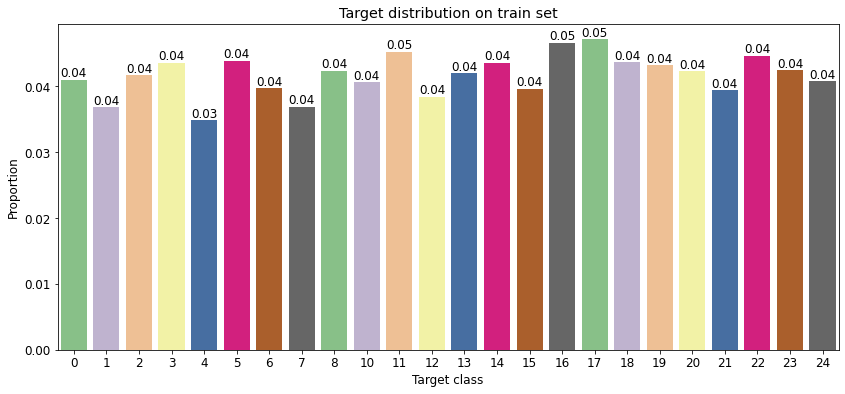

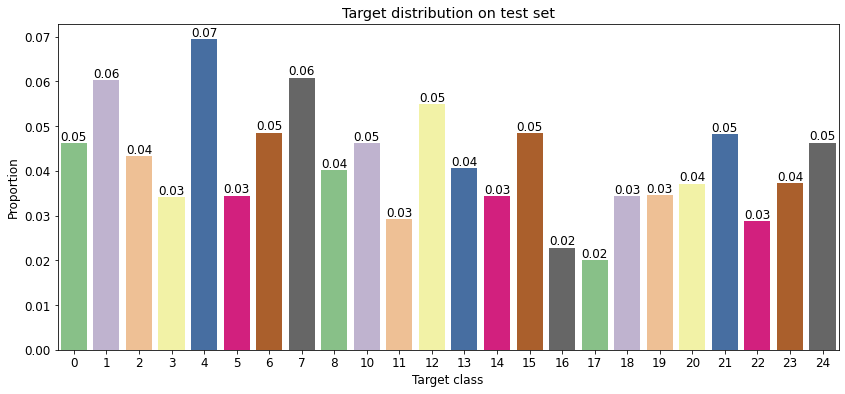

In [6]:
# plot label distribution
val_cnt = train['label'].value_counts(normalize=True)
fig = plt.figure(figsize=(14,6))
ax = sns.barplot(x=val_cnt.index, y=val_cnt, palette='Accent')
plt.title('Target distribution on train set')
plt.xlabel('Target class')
plt.ylabel('Proportion')
plt.bar_label(ax.containers[0], fmt='%.2f')
plt.show()

val_cnt = test['label'].value_counts(normalize=True)
fig = plt.figure(figsize=(14,6))
ax = sns.barplot(x=val_cnt.index, y=val_cnt, palette='Accent')
plt.title('Target distribution on test set')
plt.xlabel('Target class')
plt.ylabel('Proportion')
plt.bar_label(ax.containers[0], fmt='%.2f')
plt.show()

- there are no examples in both train set and test set with label 9
- train set target classes are not highly imbalanced

#### Image Visualization

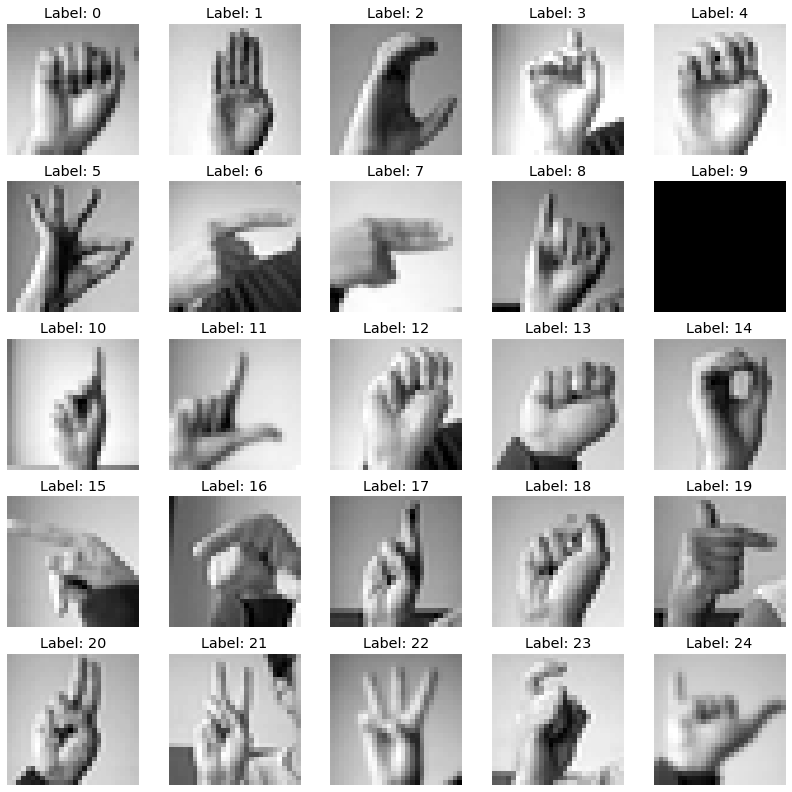

In [7]:
fig, axs = plt.subplots(5, 5, figsize=(14, 14))
axs = np.ravel(axs)
for i, ax in enumerate(axs):
    if i == 9:
        img = np.ones((28,28))
    else:
        idx = train.query(f'label == {i}').sample(1).index # returns array of indices
        img = train.values[idx[0], 1:].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {i}')
    ax.set_axis_off()

plt.show()

- we could see the images pixelated because the image has a lot of details compared to its size

#### Data Preprocessing

- Separate target from features

In [8]:
X = train.drop('label', axis=1)
X_test = test.drop('label', axis=1)

y = keras.utils.to_categorical(train['label'])
y_test = keras.utils.to_categorical(test['label'])

- reshape images to be compatible with model

In [9]:
def reshape_bw(X):
    samples, width, channel = X.shape[0], np.sqrt(X.shape[1]) , 1
    width = int(width)
    return X.values.reshape(samples, width, width, channel)

In [10]:
X = reshape_bw(X)
X_test = reshape_bw(X_test)

#### Data Splitting
- split data into train and validation set for model training and selection respectively
- split but try to keep target distribution same as before spliting

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#### Data Augmentator Instantiation
- create data augmentor and fit it on train set to compute statistics like mean and standard deviation

In [12]:
# feature = pixel
generator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, # make pixel intensity mean = 0
    featurewise_std_normalization=True, # make pixel intensity s.d. = 1
    height_shift_range=0.2, # shift image vertically (up or down) by 0.2 * 28 pixel
    width_shift_range=0.2, # shift image horizontally (left or right) by 0.2 * 28 pixel
    fill_mode='nearest'
)
generator.fit(X_train)

In [13]:
# plot each epoch's training and validation metrics
def plot_learning_curve(history):
    ephs = np.arange(0, len(history.history['loss'])) + 1
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(ephs, history.history['accuracy'], '--')
    plt.plot(ephs, history.history['val_accuracy'], '--')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.subplot(1,2,2)
    plt.plot(ephs, history.history['loss'], '--')
    plt.plot(ephs, history.history['val_loss'], '--')
    plt.legend(['loss', 'val_loss'])
    plt.show()

In [14]:
# evaluate model on unseen data and print classification report
def evaluate(model):
    loss, acc, pre, rec, f1 = model.evaluate(generator.flow(X_test, y_test, batch_size=batch_size))
    print()
    print(f"test loss: {loss}")
    print(f"test accuracy: {round(acc*100,2)} %")
    print(f"test precision: {pre}")
    print(f"test recall: {rec}")
    print(f"test f1: {f1}")
    predictions = np.argmax(model.predict(X_test), axis=-1)
    classes = [str(i) for i in range(y_test.shape[1]) if i!= 9]
    print(classification_report(np.argmax(y_test, axis=-1), predictions, target_names=classes))

In [15]:
# provide a bunch of useful callbacks for models
def get_callbacks(file_path):
    return [
          keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', mode='max', factor=0.3, patience=2, min_lr=0.00001),
          keras.callbacks.ModelCheckpoint(file_path, monitor='val_f1_score', mode='max', save_best_only=True),
          keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', restore_best_weights=True, min_delta=1e-8, patience=3)
  ]

#### Model Building and Evaluation
- typical CNN with 3 Convolutional Max pooling layer pairs and a Fully Connected layer

In [18]:
keras.backend.clear_session()
baseline_model = keras.models.Sequential()
baseline_model.add(keras.layers.Input(shape=X.shape[1:]))
baseline_model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
baseline_model.add(keras.layers.MaxPool2D((2, 2)))
baseline_model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
baseline_model.add(keras.layers.MaxPool2D((2, 2)))
baseline_model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
baseline_model.add(keras.layers.MaxPool2D((2, 2)))
baseline_model.add(keras.layers.Flatten())
baseline_model.add(keras.layers.Dense(y.shape[1], activation='softmax'))

# compile model
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy', 
        keras.metrics.Precision(), 
        keras.metrics.Recall(), 
        tfa.metrics.F1Score(num_classes=y.shape[1], average=f1_avg)
    ]
)

In [19]:
baseline_path = 'baseline.h5'
history_baseline = baseline_model.fit(
    generator.flow(X_train, y_train, batch_size=batch_size),
    epochs=20,
    validation_data=generator.flow(X_val, y_val, batch_size=batch_size),
    callbacks=get_callbacks(baseline_path),
    verbose=2
)

Epoch 1/20
344/344 - 9s - loss: 1.4955 - accuracy: 0.5413 - precision: 0.8360 - recall: 0.3815 - f1_score: 0.5403 - val_loss: 0.5823 - val_accuracy: 0.8150 - val_precision: 0.8918 - val_recall: 0.7370 - val_f1_score: 0.8116
Epoch 2/20
344/344 - 7s - loss: 0.3662 - accuracy: 0.8857 - precision: 0.9220 - recall: 0.8412 - f1_score: 0.8856 - val_loss: 0.2108 - val_accuracy: 0.9352 - val_precision: 0.9544 - val_recall: 0.9104 - val_f1_score: 0.9352
Epoch 3/20
344/344 - 7s - loss: 0.1633 - accuracy: 0.9501 - precision: 0.9623 - recall: 0.9375 - f1_score: 0.9501 - val_loss: 0.1384 - val_accuracy: 0.9585 - val_precision: 0.9679 - val_recall: 0.9499 - val_f1_score: 0.9585
Epoch 4/20
344/344 - 6s - loss: 0.0982 - accuracy: 0.9697 - precision: 0.9763 - recall: 0.9637 - f1_score: 0.9697 - val_loss: 0.0705 - val_accuracy: 0.9807 - val_precision: 0.9848 - val_recall: 0.9774 - val_f1_score: 0.9807
Epoch 5/20
344/344 - 7s - loss: 0.0672 - accuracy: 0.9792 - precision: 0.9829 - recall: 0.9760 - f1_scor

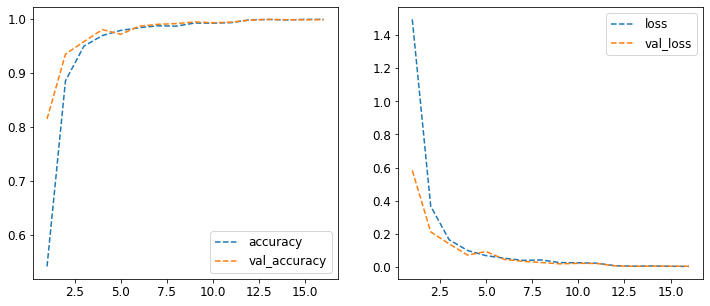

In [20]:
plot_learning_curve(history_baseline)

- reducing the learning rate when validation F1 score seems to plateau or get worse was helpful in making model not overfit to training data
- the metrics seems to stabilize after 13 th epoch

In [21]:
best_baseline = keras.models.load_model(baseline_path)
evaluate(best_baseline)

113/113 [==============================] - 2s 17ms/step - loss: 0.0292 - accuracy: 0.9912 - precision: 0.9920 - recall: 0.9905 - f1_score: 0.9912

test loss: 0.029205305501818657
test accuracy: 99.12 %
test precision: 0.99204021692276
test recall: 0.9905186891555786
test f1: 0.9912089109420776
              precision    recall  f1-score   support

           0       0.72      0.98      0.83       331
           1       0.76      0.96      0.85       432
           2       1.00      0.86      0.93       310
           3       1.00      0.57      0.72       245
           4       0.99      0.76      0.86       498
           5       1.00      0.87      0.93       247
           6       0.94      0.84      0.89       348
           7       0.75      1.00      0.86       436
           8       0.88      0.99      0.93       288
          10       1.00      0.72      0.84       331
          11       0.97      0.64      0.77       209
          12       1.00      0.82      0.90       394
  

- image from other classes are being predicted as class 14, 18 and 22 a lot
- on the other hand, class 3, 13, 19, and 21 have moderate amount of false negatives

- add some Dropout Layer to see if performance get better as the test score is far from training score
- also add one more Fully Connected Layer to help learning features

In [22]:
keras.backend.clear_session()
drop_model = keras.models.Sequential()
drop_model.add(keras.layers.Input(shape=X.shape[1:]))
drop_model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
drop_model.add(keras.layers.MaxPool2D((2, 2)))
drop_model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
drop_model.add(keras.layers.Dropout(0.1))
drop_model.add(keras.layers.MaxPool2D((2, 2)))
drop_model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
drop_model.add(keras.layers.Dropout(0.2))
drop_model.add(keras.layers.MaxPool2D((2, 2)))
drop_model.add(keras.layers.Flatten())
drop_model.add(keras.layers.Dense(128, activation='relu'))
drop_model.add(keras.layers.Dropout(0.2))
drop_model.add(keras.layers.Dense(y.shape[1], activation='softmax'))

# compile model
drop_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy', 
        keras.metrics.Precision(), 
        keras.metrics.Recall(), 
        tfa.metrics.F1Score(num_classes=y.shape[1], average=f1_avg)
    ]
)

In [23]:
dropout_path = 'dropout.h5'
history_dropout = drop_model.fit(
    generator.flow(X_train, y_train, batch_size=batch_size),
    epochs=20,
    validation_data=generator.flow(X_val, y_val, batch_size=batch_size),
    callbacks=get_callbacks(dropout_path),
    verbose=2
)

Epoch 1/20
344/344 - 8s - loss: 1.6787 - accuracy: 0.4731 - precision: 0.7712 - recall: 0.2974 - f1_score: 0.4710 - val_loss: 0.6302 - val_accuracy: 0.8354 - val_precision: 0.9265 - val_recall: 0.6747 - val_f1_score: 0.8331
Epoch 2/20
344/344 - 7s - loss: 0.4906 - accuracy: 0.8344 - precision: 0.8850 - recall: 0.7810 - f1_score: 0.8340 - val_loss: 0.2449 - val_accuracy: 0.9348 - val_precision: 0.9613 - val_recall: 0.9007 - val_f1_score: 0.9350
Epoch 3/20
344/344 - 7s - loss: 0.2681 - accuracy: 0.9104 - precision: 0.9323 - recall: 0.8905 - f1_score: 0.9104 - val_loss: 0.1235 - val_accuracy: 0.9690 - val_precision: 0.9767 - val_recall: 0.9554 - val_f1_score: 0.9690
Epoch 4/20
344/344 - 7s - loss: 0.1679 - accuracy: 0.9439 - precision: 0.9545 - recall: 0.9340 - f1_score: 0.9439 - val_loss: 0.0745 - val_accuracy: 0.9823 - val_precision: 0.9873 - val_recall: 0.9752 - val_f1_score: 0.9824
Epoch 5/20
344/344 - 7s - loss: 0.1213 - accuracy: 0.9599 - precision: 0.9660 - recall: 0.9536 - f1_scor

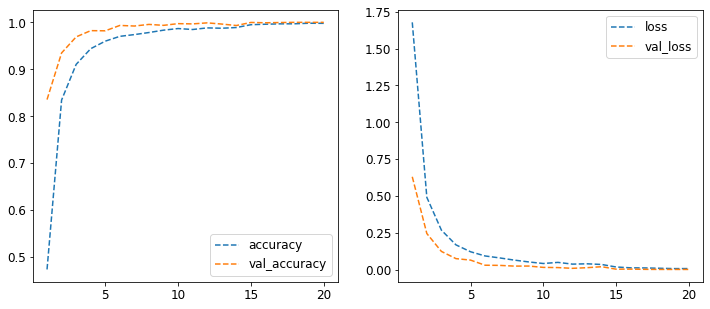

In [24]:
plot_learning_curve(history_dropout)

- validation set performance has been leading training set performance throughout the training
- validation performance metrics seems to be maximized

In [25]:
best_dropout = keras.models.load_model(dropout_path)
evaluate(best_dropout)

113/113 [==============================] - 3s 19ms/step - loss: 0.0113 - accuracy: 0.9965 - precision: 0.9968 - recall: 0.9962 - f1_score: 0.9965

test loss: 0.011279232800006866
test accuracy: 99.65 %
test precision: 0.9967913031578064
test recall: 0.9962353706359863
test f1: 0.996514081954956
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       331
           1       0.89      0.99      0.93       432
           2       0.97      0.91      0.94       310
           3       0.94      0.88      0.91       245
           4       0.94      0.99      0.97       498
           5       0.88      1.00      0.94       247
           6       0.83      1.00      0.91       348
           7       1.00      0.92      0.96       436
           8       1.00      0.95      0.98       288
          10       1.00      0.78      0.88       331
          11       0.99      0.95      0.97       209
          12       0.94      0.88      0.91       394
 

- test set performance (weighted average F1) seems to be improved by 8 % which is a good sign
- it is likely that further tuning could improve F1 score of target class 17, 20, 21 and 23

- after some searching, there was a finding that popular CNN models like ResNet stack convolutional layers
- the architecture below tries to adapt some characteristic of ResNet model with previous model

In [26]:
keras.backend.clear_session()
drop_model2 = keras.models.Sequential()
drop_model2.add(keras.layers.Input(shape=X.shape[1:]))
drop_model2.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
drop_model2.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
drop_model2.add(keras.layers.Dropout(0.1))
drop_model2.add(keras.layers.MaxPool2D((2, 2)))
drop_model2.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
drop_model2.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
drop_model2.add(keras.layers.Dropout(0.2))
drop_model2.add(keras.layers.MaxPool2D((2, 2)))
drop_model2.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
drop_model2.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
drop_model2.add(keras.layers.Dropout(0.3))
drop_model2.add(keras.layers.MaxPool2D((2, 2)))
drop_model2.add(keras.layers.Flatten())
drop_model2.add(keras.layers.Dense(128, activation='relu'))
drop_model2.add(keras.layers.Dropout(0.2))
drop_model2.add(keras.layers.Dense(y.shape[1], activation='softmax'))

# compile model
drop_model2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy', 
        keras.metrics.Precision(), 
        keras.metrics.Recall(), 
        tfa.metrics.F1Score(num_classes=y.shape[1], average=f1_avg)
    ]
)

In [27]:
dropout_path2 = 'dropout2.h5'
history_dropout2 = drop_model2.fit(
    generator.flow(X_train, y_train, batch_size=batch_size),
    epochs=20,
    validation_data=generator.flow(X_val, y_val, batch_size=batch_size),
    callbacks=get_callbacks(dropout_path2),
    verbose=2
)

Epoch 1/20
344/344 - 8s - loss: 1.6189 - accuracy: 0.4928 - precision: 0.7862 - recall: 0.3606 - f1_score: 0.4916 - val_loss: 0.4336 - val_accuracy: 0.9002 - val_precision: 0.9520 - val_recall: 0.7944 - val_f1_score: 0.9002
Epoch 2/20
344/344 - 7s - loss: 0.2660 - accuracy: 0.9106 - precision: 0.9296 - recall: 0.8912 - f1_score: 0.9106 - val_loss: 0.1066 - val_accuracy: 0.9763 - val_precision: 0.9832 - val_recall: 0.9689 - val_f1_score: 0.9764
Epoch 3/20
344/344 - 8s - loss: 0.1176 - accuracy: 0.9621 - precision: 0.9676 - recall: 0.9569 - f1_score: 0.9621 - val_loss: 0.0484 - val_accuracy: 0.9924 - val_precision: 0.9950 - val_recall: 0.9874 - val_f1_score: 0.9923
Epoch 4/20
344/344 - 7s - loss: 0.0722 - accuracy: 0.9767 - precision: 0.9789 - recall: 0.9740 - f1_score: 0.9767 - val_loss: 0.0312 - val_accuracy: 0.9956 - val_precision: 0.9973 - val_recall: 0.9933 - val_f1_score: 0.9956
Epoch 5/20
344/344 - 7s - loss: 0.0444 - accuracy: 0.9848 - precision: 0.9868 - recall: 0.9834 - f1_scor

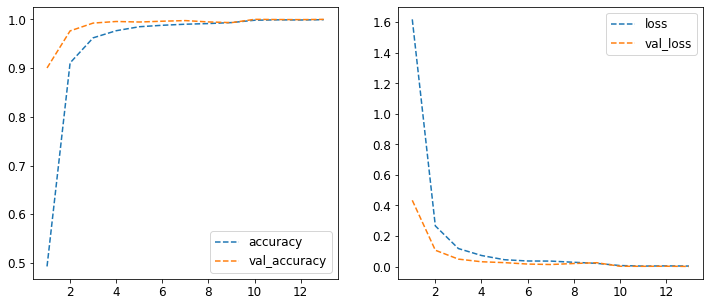

In [28]:
plot_learning_curve(history_dropout2)

- validation performance seems to be better than training
- the model performance stabilized much earlier which made the early stopping callback cease training

In [29]:
best_dropout2 = keras.models.load_model(dropout_path2)
evaluate(best_dropout2)

113/113 [==============================] - 2s 17ms/step - loss: 0.0144 - accuracy: 0.9960 - precision: 0.9962 - recall: 0.9955 - f1_score: 0.9959

test loss: 0.014396986924111843
test accuracy: 99.6 %
test precision: 0.9962327480316162
test recall: 0.9955381751060486
test f1: 0.9959484934806824
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      0.92      0.96       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       0.98      1.00      0.99       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
          10       1.00      1.00      1.00       331
          11       1.00      1.00      1.00       209
          12       1.00      1.00      1.00       394
 

- stacking convolutional layers seems to be effective
- weighted F1 score nearly reached the maximal value

- previously, dropout layers were used to prevent overfitting
- small kernel size might lead to overfitting because it take a lot details in training data into account
- the next architecture will have dropout layers removed but instead larger kernel size will be used for better generalization at the cost of losing details that could be captured in training data

In [46]:
keras.backend.clear_session()
drop_model3 = keras.models.Sequential()
drop_model3.add(keras.layers.Input(shape=X.shape[1:]))
drop_model3.add(keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
drop_model3.add(keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
drop_model3.add(keras.layers.MaxPool2D((2, 2)))
drop_model3.add(keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
drop_model3.add(keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
drop_model3.add(keras.layers.MaxPool2D((2, 2)))
drop_model3.add(keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
drop_model3.add(keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
drop_model3.add(keras.layers.MaxPool2D((2, 2)))
drop_model3.add(keras.layers.Flatten())
drop_model3.add(keras.layers.Dense(128, activation='relu'))
drop_model3.add(keras.layers.Dropout(0.2))
drop_model3.add(keras.layers.Dense(y.shape[1], activation='softmax'))

# compile model
drop_model3.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy', 
        keras.metrics.Precision(), 
        keras.metrics.Recall(), 
        tfa.metrics.F1Score(num_classes=y.shape[1], average=f1_avg)
    ]
)

In [47]:
dropout_path3 = 'dropout3.h5'
history_dropout3 = drop_model3.fit(
    generator.flow(X_train, y_train, batch_size=batch_size),
    epochs=20,
    validation_data=generator.flow(X_val, y_val, batch_size=batch_size),
    callbacks=get_callbacks(dropout_path3),
    verbose=2
)

Epoch 1/20
344/344 - 9s - loss: 1.5612 - accuracy: 0.5109 - precision: 0.8204 - recall: 0.3978 - f1_score: 0.5130 - val_loss: 0.2396 - val_accuracy: 0.9244 - val_precision: 0.9413 - val_recall: 0.9029 - val_f1_score: 0.9229
Epoch 2/20
344/344 - 7s - loss: 0.1450 - accuracy: 0.9551 - precision: 0.9627 - recall: 0.9466 - f1_score: 0.9551 - val_loss: 0.0655 - val_accuracy: 0.9778 - val_precision: 0.9804 - val_recall: 0.9749 - val_f1_score: 0.9779
Epoch 3/20
344/344 - 7s - loss: 0.0558 - accuracy: 0.9831 - precision: 0.9852 - recall: 0.9809 - f1_score: 0.9831 - val_loss: 0.0190 - val_accuracy: 0.9938 - val_precision: 0.9945 - val_recall: 0.9931 - val_f1_score: 0.9938
Epoch 4/20
344/344 - 7s - loss: 0.0407 - accuracy: 0.9881 - precision: 0.9895 - recall: 0.9863 - f1_score: 0.9881 - val_loss: 0.0156 - val_accuracy: 0.9951 - val_precision: 0.9962 - val_recall: 0.9949 - val_f1_score: 0.9951
Epoch 5/20
344/344 - 7s - loss: 0.0469 - accuracy: 0.9878 - precision: 0.9893 - recall: 0.9856 - f1_scor

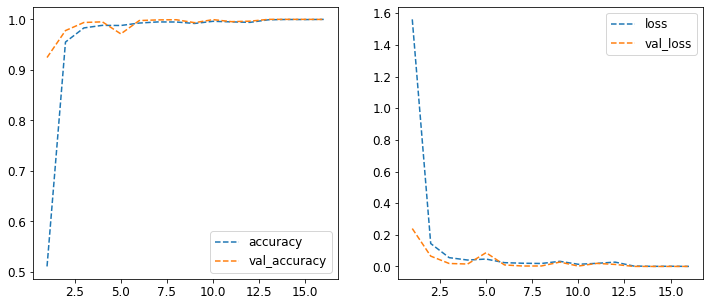

In [48]:
plot_learning_curve(history_dropout3)

- there were fluctuations in validation metrics until the 13 th epoch
- validation performance reached the maximum and there was nothing to improve making the training stopped at 16 th epoch

In [49]:
best_dropout3 = keras.models.load_model(dropout_path3)
evaluate(best_dropout3)

113/113 [==============================] - 3s 21ms/step - loss: 0.0199 - accuracy: 0.9954 - precision: 0.9957 - recall: 0.9951 - f1_score: 0.9954

test loss: 0.019933709874749184
test accuracy: 99.54 %
test precision: 0.9956752061843872
test recall: 0.9951199293136597
test f1: 0.9953896999359131
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       331
           1       1.00      0.95      0.97       432
           2       1.00      0.98      0.99       310
           3       1.00      1.00      1.00       245
           4       1.00      0.98      0.99       498
           5       1.00      0.99      1.00       247
           6       0.87      0.95      0.91       348
           7       0.99      0.89      0.94       436
           8       1.00      0.98      0.99       288
          10       0.99      0.98      0.98       331
          11       1.00      1.00      1.00       209
          12       1.00      1.00      1.00       394


- increasing kernel size let us extract feature in a larger region and ignore unimportant little details that could mislead us
- after increasing kernel size to 5, model performed a little worse than using orginal kernel size of 3 with dropout layers

#### CNN Kernel and Output Visualization

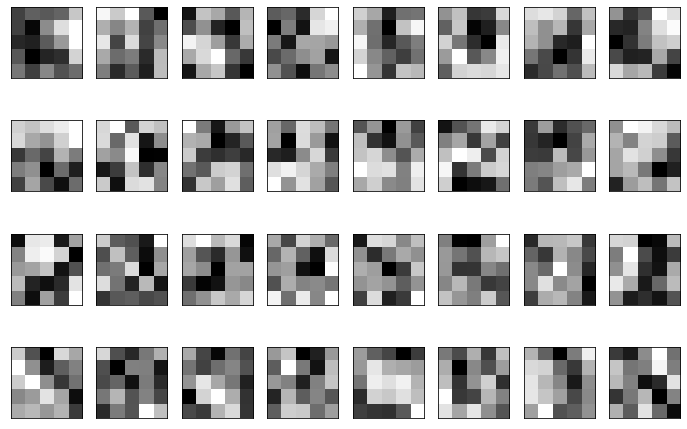

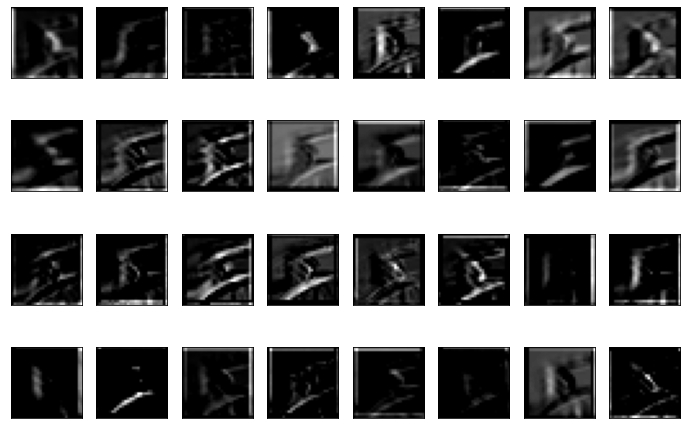

In [50]:
# cr. https://github.com/bnsreenu/python_for_microscopists/blob/master/152-visualizing_conv_layer_outputs.py
layer = best_dropout3.layers
idx = 0
filters, biases = best_dropout3.layers[idx].get_weights()  

main_fig = plt.figure(figsize=(12, 8))
columns = 8
rows = 4
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig = plt.subplot(rows, columns, i)
    fig.set_xticks([]) 
    fig.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray')
plt.show()    

conv_layer_index = [0, 1, 4, 5, 8, 9]
conv_layer_index = [0]
outputs = [best_dropout3.layers[i].output for i in conv_layer_index]
model_short = keras.models.Model(inputs=best_dropout3.inputs, outputs=[outputs])

feature_output = model_short.predict(X_test[0:1])


columns = 8
rows = 4
for ftr in feature_output:
    fig = plt.figure(figsize=(12, 8))
    for i in range(1, columns*rows +1):
        fig = plt.subplot(rows, columns, i)
        fig.set_xticks([])
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :, i-1], cmap='gray')
    plt.show()